<h1> Cuda verification </h1>

In [6]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


<h1>Augmentation pipeline </h1>

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([
    # --- Geometric Augmentations ---
    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=1.0),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),

    # --- Color and Brightness Augmentations ---
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),

    # --- Noise and Occlusion Augmentations ---
    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.3),
        A.RandomRain(slant_range=(-15, 15), drop_length=15, drop_width=1, rain_type="default", blur_value=7, p=0.3),
        A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.3)
    ], p=0.5),

    # --- Final Steps ---
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

<h2>Data preparation</h2>

In [5]:
import random
import shutil
from tqdm import tqdm
from pathlib import Path

def prepare_image_datasets(source_dir, base_dir, split_ratios=(0.7, 0.2, 0.1)):

     if not (0.999 < sum(split_ratios) < 1.001):
             raise ValueError('split_ratios must sum to 1')

     source_path = Path(source_dir)
     base_path = Path(base_dir)

     if not source_path.is_dir():
         print(f'Source directory {source_path.name} does not exist')
         return

     train_path = base_path / 'train'
     test_path = base_path / 'test'
     val_path = base_path / 'val'

     class_names = [d.name for d in source_path.iterdir() if d.is_dir()]

     if not class_names:
         print(f'Source directory {source_path.name} does not contain any class names')
         return

     for directory in [train_path, test_path, val_path]:
         for class_name in class_names:
             (directory / class_name).mkdir(parents=True, exist_ok=True)

     for class_name in class_names:

         class_source_path = source_path / class_name

         files = [f for f in class_source_path.iterdir() if f.is_file()]

         random.shuffle(files)

         total_files = len(files)
         train_end = int(total_files * split_ratios[0])
         test_end = train_end + int(total_files * split_ratios[1])

         split_data = {
             'train': (files[:train_end], train_path),
             'test': (files[train_end:test_end], test_path),
             'val': (files[test_end:], val_path)
         }

         print(f"Copying {class_name} to {base_path}")

         for split_name, (file_list, destination_path) in split_data.items():

             dest_class_path = destination_path / class_name

             for file_path in tqdm(file_list, desc=f'Copying {split_name} files'):

                 shutil.copy2(file_path, dest_class_path / file_path.name)

         print(f'Copying {class_name} finished!')

     print("Data splitting successful!")


In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

# data = CustomDataset(root='dataset', transform=training_pipeline)

# image, path = data[0]
#
# print(path)
#
# image = image.permute(1,2,0).numpy()
#
# image = (image * np
#          .array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
# image = np.clip(image, 0, 1)
# image = (image * 255).astype(np.uint8)
#
# plt.imshow(image)
# plt.show()

<h2> Data splitting </h2>

In [6]:
source_data_dir = r'C:\Users\LANCE\OneDrive\Desktop\rice_pest\Finalized_datasets'
base_data_dir = r'C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets'

if not source_data_dir or not base_data_dir:
    raise ValueError('Source and base data directory not found')

prepare_image_datasets(source_data_dir, base_data_dir, split_ratios=(0.7, 0.2, 0.1))


Copying brown-planthopper to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 246/246 [00:00<00:00, 1087.34it/s]


Copying brown-planthopper finished!
Copying green-leafhopper to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 215/215 [00:00<00:00, 1213.62it/s]


Copying green-leafhopper finished!
Copying rice-black-bug to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 16/16 [00:00<00:00, 913.85it/s]


Copying rice-black-bug finished!
Copying rice-leaf-folder to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 275/275 [00:00<00:00, 1070.15it/s]


Copying rice-leaf-folder finished!
Copying stem-borer to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 197/197 [00:00<00:00, 923.07it/s] 


Copying stem-borer finished!
Copying whorl-maggot to C:\Users\LANCE\OneDrive\Desktop\rice_pest\datasets


Copying val files: 100%|██████████| 125/125 [00:00<00:00, 1097.27it/s]

Copying whorl-maggot finished!
Data splitting successful!


<h2> Training functions and hyperparameters</h2>

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class LSoftmax(nn.Module):

    def __init__(self, input_features, number_of_classes, m=4):
        super(LSoftmax, self).__init__()
        self.input_features = input_features
        self.number_of_classes = number_of_classes
        self.m = m

        if m <= 1:
            raise ValueError('m must be greater than 1')

        # Initialization of weights through xavier uniform.
        self.weight = nn.Parameter(torch.FloatTensor(number_of_classes,  input_features))
        nn.init.xavier_uniform_(self.weight)

    # Forward propagation
    def forward(self, x, labels=None):

        # normalization of weights and input vector features.
        normalize_weight = F.normalize(self.weight, p=2, dim=1)
        normalize_x = F.normalize(x, p=2, dim=1)

        # Cosine similarity: perform DOT product multiplication between weights and input vectors.
        # cos_theta = F.linear(normalize_x, normalize_weight.t())

        cos_theta = F.linear(normalize_x, normalize_weight)

        if labels is None:
            return cos_theta

        cos_theta = cos_theta.clamp(-1,1)

        # Convert cosine similarity into actual angles.
        theta = torch.acos(cos_theta)

        # Gathered the correct classes as one vector and reshape it in to a 2d with one column.
        target_theta = theta.gather(1, labels.view(-1,1))

        # applies the margin to the correct classes
        m_theta = self.m * target_theta
        k = (m_theta / math.pi).floor()

        # Compute the angular margin to get a new hard target score for prediction
        psi_theta = ((-1)**k) * torch.cos(m_theta) - (2*k)

        # Scattered the new values got from psi_theta to its corresponding classes
        final_logits = cos_theta.scatter(1, labels.view(-1,1), psi_theta)

        return final_logits


In [9]:
import torchvision.models as models

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes, margin):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: Instantiate LSoftmax as new customized final layer.
        self.base_model.classifier[1] = LSoftmax(
            input_features=num_filters,
            number_of_classes=num_classes,
            m=margin
        )

    # Forward propagation
    def forward(self, x, labels=None):

        # Passed the features in feature extraction layer.
        features = self.base_model.features(x)

        # Adaptive average pooling: returns a 2d scaled vector features.
        features = F.adaptive_avg_pool2d(features, (1,1)).reshape(features.shape[0], -1)

        # Implementation of the LSoftmax through passing the feature vectors and class for classification.
        logits = self.base_model.classifier[1](features, labels)

        # return the result logits
        return logits

    def unfreeze_last_block(self):
        print("\nUnfreezing the last convolutional block for fine-tuning...")

        for param in self.base_model.features[-1].parameters():
            param.requires_grad = True

    def unfreeze_before_last_block(self):
        print("\nUnfreezing the before last convolutional block for fine-tuning...")

        for param in self.base_model.features[-2].parameters():
            param.requires_grad = True

    def unfreeze_third_last_inverse_residual(self):
        print("\nUnfreezing the third last convolutional block for fine-tuning...")

        for param in self.base_model.features[-3].parameters():
            param.requires_grad = True

    def unfreeze_fourth_last_inverse_residual(self):
        print("\nUnfreezing the fourth last convolutional block for fine-tuning...")

        for param in self.base_model.features[-4].parameters():
            param.requires_grad = True

In [11]:
import torch
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device):
    train_losses = []
    test_losses = []
    accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data, labels)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs, labels)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()

                output_predictions = model(inputs, labels=None)
                _, predicted = torch.max(output_predictions.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.2f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/V2/Advance/MobileNetV2_rice_pest_classificationV5.pt')

    tqdm.write('Phase done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

<h3> Data loader </h3>

In [13]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
validation_set = CustomDataset(root='datasets/val', transform=validation_pipeline)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

classes = train_set.classes

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def plot_training_result(*results):

    full_train_loss = []
    full_test_loss = []

    for res in results:
        full_train_loss.extend(res.get('train_loss', []))
        full_test_loss.extend(res.get('test_loss', []))

    total_epochs = len(full_train_loss)
    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_train_loss,
        'Testing Loss': full_test_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for result in results:
        accuracy = result.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)
    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(*histories, filename='MobileNetV2_rice_pest_classificationV5.csv'):

    full_train_loss = []
    full_test_loss = []
    full_accuracy = []

    for history in histories:

        full_train_loss.extend(history.get('train_loss', []))
        full_test_loss.extend(history.get('test_loss', []))
        full_accuracy.extend(history.get('accuracy', []))

    data_dict = pd.DataFrame({
        'train_loss': full_train_loss,
        'test_loss': full_test_loss,
        'accuracy': full_accuracy,
    })

    if os.path.exists(filename):
        print("Existing historical data exists! Appending new data.")

        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'test_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")

Phase 1


Test epoch: 1: 100%|██████████| 34/34 [00:07<00:00,  4.74it/s]


Epoch 1/15 | Train Loss: 3.1965 | Test Loss: 3.0356 | Accuracy: 39.35% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 2/15 | Train Loss: 3.0200 | Test Loss: 3.0007 | Accuracy: 50.33% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 3/15 | Train Loss: 3.0033 | Test Loss: 2.9876 | Accuracy: 58.68% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 4/15 | Train Loss: 2.9959 | Test Loss: 2.9729 | Accuracy: 63.09% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 5/15 | Train Loss: 2.9906 | Test Loss: 2.9662 | Accuracy: 64.26% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 6/15 | Train Loss: 2.9874 | Test Loss: 2.9590 | Accuracy: 65.48% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 7/15 | Train Loss: 2.9845 | Test Loss: 2.9570 | Accuracy: 65.24% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 8/15 | Train Loss: 2.9845 | Test Loss: 2.9530 | Accuracy: 66.84% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 9/15 | Train Loss: 2.9827 | Test Loss: 2.9556 | Accuracy: 65.99% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 10/15 | Train Loss: 2.9831 | Test Loss: 2.9491 | Accuracy: 67.68% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 11/15 | Train Loss: 2.9816 | Test Loss: 2.9521 | Accuracy: 65.99% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]


Epoch 12/15 | Train Loss: 2.9806 | Test Loss: 2.9490 | Accuracy: 69.61% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


Epoch 13/15 | Train Loss: 2.9813 | Test Loss: 2.9501 | Accuracy: 69.89% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 14: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 14/15 | Train Loss: 2.9812 | Test Loss: 2.9489 | Accuracy: 67.26% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 15/15 | Train Loss: 2.9803 | Test Loss: 2.9480 | Accuracy: 66.51% | GPU Memory (Alloc/Reserved): 0.14/1.830 GB
Training done!
Phase 2

Unfreezing the last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


Epoch 1/30 | Train Loss: 2.9773 | Test Loss: 2.9368 | Accuracy: 69.37% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 2/30 | Train Loss: 2.9729 | Test Loss: 2.9264 | Accuracy: 71.06% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 3/30 | Train Loss: 2.9674 | Test Loss: 2.9175 | Accuracy: 72.80% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 4/30 | Train Loss: 2.9626 | Test Loss: 2.9077 | Accuracy: 73.22% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 5/30 | Train Loss: 2.9576 | Test Loss: 2.8955 | Accuracy: 73.50% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 6/30 | Train Loss: 2.9527 | Test Loss: 2.8862 | Accuracy: 74.25% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 7/30 | Train Loss: 2.9489 | Test Loss: 2.8784 | Accuracy: 74.39% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 8/30 | Train Loss: 2.9440 | Test Loss: 2.8653 | Accuracy: 74.77% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 9: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 9/30 | Train Loss: 2.9374 | Test Loss: 2.8565 | Accuracy: 74.67% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 10/30 | Train Loss: 2.9309 | Test Loss: 2.8393 | Accuracy: 73.64% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 11/30 | Train Loss: 2.9280 | Test Loss: 2.8213 | Accuracy: 72.75% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.70it/s]


Epoch 12/30 | Train Loss: 2.9164 | Test Loss: 2.7966 | Accuracy: 72.14% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 13: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 13/30 | Train Loss: 2.9075 | Test Loss: 2.7723 | Accuracy: 71.81% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 14/30 | Train Loss: 2.8926 | Test Loss: 2.7412 | Accuracy: 70.64% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 15/30 | Train Loss: 2.8841 | Test Loss: 2.7116 | Accuracy: 69.23% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.44it/s]


Epoch 16/30 | Train Loss: 2.8703 | Test Loss: 2.6805 | Accuracy: 70.22% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 17: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Epoch 17/30 | Train Loss: 2.8568 | Test Loss: 2.6478 | Accuracy: 68.71% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 18: 100%|██████████| 34/34 [00:08<00:00,  4.14it/s]


Epoch 18/30 | Train Loss: 2.8443 | Test Loss: 2.6116 | Accuracy: 69.18% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 19/30 | Train Loss: 2.8289 | Test Loss: 2.5813 | Accuracy: 68.86% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Epoch 20/30 | Train Loss: 2.8152 | Test Loss: 2.5441 | Accuracy: 68.95% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 21/30 | Train Loss: 2.8003 | Test Loss: 2.5018 | Accuracy: 69.18% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 22: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]


Epoch 22/30 | Train Loss: 2.7798 | Test Loss: 2.4603 | Accuracy: 69.47% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 23/30 | Train Loss: 2.7595 | Test Loss: 2.4284 | Accuracy: 69.65% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 24: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


Epoch 24/30 | Train Loss: 2.7457 | Test Loss: 2.3764 | Accuracy: 70.31% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]


Epoch 25/30 | Train Loss: 2.7192 | Test Loss: 2.3437 | Accuracy: 71.15% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 26: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 26/30 | Train Loss: 2.6975 | Test Loss: 2.3125 | Accuracy: 70.97% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 27/30 | Train Loss: 2.6874 | Test Loss: 2.2825 | Accuracy: 70.92% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 28/30 | Train Loss: 2.6706 | Test Loss: 2.2525 | Accuracy: 70.97% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 29/30 | Train Loss: 2.6527 | Test Loss: 2.2320 | Accuracy: 70.83% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 30/30 | Train Loss: 2.6292 | Test Loss: 2.2074 | Accuracy: 71.11% | GPU Memory (Alloc/Reserved): 0.15/1.832 GB
Training done!
Phase 3

Unfreezing the before last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 1/45 | Train Loss: 2.5817 | Test Loss: 2.1385 | Accuracy: 71.34% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.38it/s]


Epoch 2/45 | Train Loss: 2.5154 | Test Loss: 2.0587 | Accuracy: 72.80% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 3/45 | Train Loss: 2.4439 | Test Loss: 1.9947 | Accuracy: 74.16% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 4: 100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


Epoch 4/45 | Train Loss: 2.4089 | Test Loss: 1.9541 | Accuracy: 74.67% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 5: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 5/45 | Train Loss: 2.3701 | Test Loss: 1.9163 | Accuracy: 75.52% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 6/45 | Train Loss: 2.3469 | Test Loss: 1.8799 | Accuracy: 75.52% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 7/45 | Train Loss: 2.3042 | Test Loss: 1.8586 | Accuracy: 75.47% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 8: 100%|██████████| 34/34 [00:06<00:00,  5.46it/s]


Epoch 8/45 | Train Loss: 2.2861 | Test Loss: 1.8393 | Accuracy: 76.17% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 9/45 | Train Loss: 2.2615 | Test Loss: 1.8153 | Accuracy: 77.30% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 10/45 | Train Loss: 2.2557 | Test Loss: 1.8018 | Accuracy: 78.24% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 11/45 | Train Loss: 2.2289 | Test Loss: 1.7830 | Accuracy: 78.10% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 12: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 12/45 | Train Loss: 2.2186 | Test Loss: 1.7713 | Accuracy: 78.56% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 13/45 | Train Loss: 2.1957 | Test Loss: 1.7611 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 14/45 | Train Loss: 2.1887 | Test Loss: 1.7566 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.42it/s]


Epoch 15/45 | Train Loss: 2.1715 | Test Loss: 1.7314 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.46it/s]


Epoch 16/45 | Train Loss: 2.1653 | Test Loss: 1.7184 | Accuracy: 80.21% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 17/45 | Train Loss: 2.1523 | Test Loss: 1.7067 | Accuracy: 80.82% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 18/45 | Train Loss: 2.1517 | Test Loss: 1.6960 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 19/45 | Train Loss: 2.1384 | Test Loss: 1.6866 | Accuracy: 81.71% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 20/45 | Train Loss: 2.1081 | Test Loss: 1.6606 | Accuracy: 82.55% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 21/45 | Train Loss: 2.1171 | Test Loss: 1.6606 | Accuracy: 82.27% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 22: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 22/45 | Train Loss: 2.1009 | Test Loss: 1.6404 | Accuracy: 83.35% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 23/45 | Train Loss: 2.0870 | Test Loss: 1.6344 | Accuracy: 83.16% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 24/45 | Train Loss: 2.0840 | Test Loss: 1.6195 | Accuracy: 83.44% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 25/45 | Train Loss: 2.0824 | Test Loss: 1.6075 | Accuracy: 83.82% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 26/45 | Train Loss: 2.0750 | Test Loss: 1.5972 | Accuracy: 83.96% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 27/45 | Train Loss: 2.0677 | Test Loss: 1.5824 | Accuracy: 84.15% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 28/45 | Train Loss: 2.0635 | Test Loss: 1.5867 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 29/45 | Train Loss: 2.0307 | Test Loss: 1.5759 | Accuracy: 84.29% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 30/45 | Train Loss: 2.0414 | Test Loss: 1.5640 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 31: 100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch 31/45 | Train Loss: 2.0414 | Test Loss: 1.5601 | Accuracy: 84.99% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 32: 100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


Epoch 32/45 | Train Loss: 2.0426 | Test Loss: 1.5528 | Accuracy: 84.76% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 33: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 33/45 | Train Loss: 2.0295 | Test Loss: 1.5451 | Accuracy: 84.99% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 34: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 34/45 | Train Loss: 2.0143 | Test Loss: 1.5386 | Accuracy: 85.13% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 35: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Epoch 35/45 | Train Loss: 2.0048 | Test Loss: 1.5272 | Accuracy: 85.65% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 36: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 36/45 | Train Loss: 2.0030 | Test Loss: 1.5286 | Accuracy: 85.23% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 37: 100%|██████████| 34/34 [00:06<00:00,  5.39it/s]


Epoch 37/45 | Train Loss: 1.9899 | Test Loss: 1.5162 | Accuracy: 85.88% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 38: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Epoch 38/45 | Train Loss: 1.9878 | Test Loss: 1.5035 | Accuracy: 85.55% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 39: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 39/45 | Train Loss: 1.9849 | Test Loss: 1.5101 | Accuracy: 85.65% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 40: 100%|██████████| 34/34 [00:06<00:00,  4.96it/s]


Epoch 40/45 | Train Loss: 1.9902 | Test Loss: 1.5024 | Accuracy: 85.74% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 41: 100%|██████████| 34/34 [00:06<00:00,  5.59it/s]


Epoch 41/45 | Train Loss: 1.9901 | Test Loss: 1.4996 | Accuracy: 85.93% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 42: 100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


Epoch 42/45 | Train Loss: 1.9852 | Test Loss: 1.5017 | Accuracy: 85.46% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 43: 100%|██████████| 34/34 [00:06<00:00,  5.34it/s]


Epoch 43/45 | Train Loss: 1.9817 | Test Loss: 1.4941 | Accuracy: 85.74% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 44: 100%|██████████| 34/34 [00:06<00:00,  5.45it/s]


Epoch 44/45 | Train Loss: 1.9656 | Test Loss: 1.4950 | Accuracy: 85.88% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB


Test epoch: 45: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 45/45 | Train Loss: 1.9857 | Test Loss: 1.4845 | Accuracy: 86.16% | GPU Memory (Alloc/Reserved): 0.16/1.834 GB
Training done!


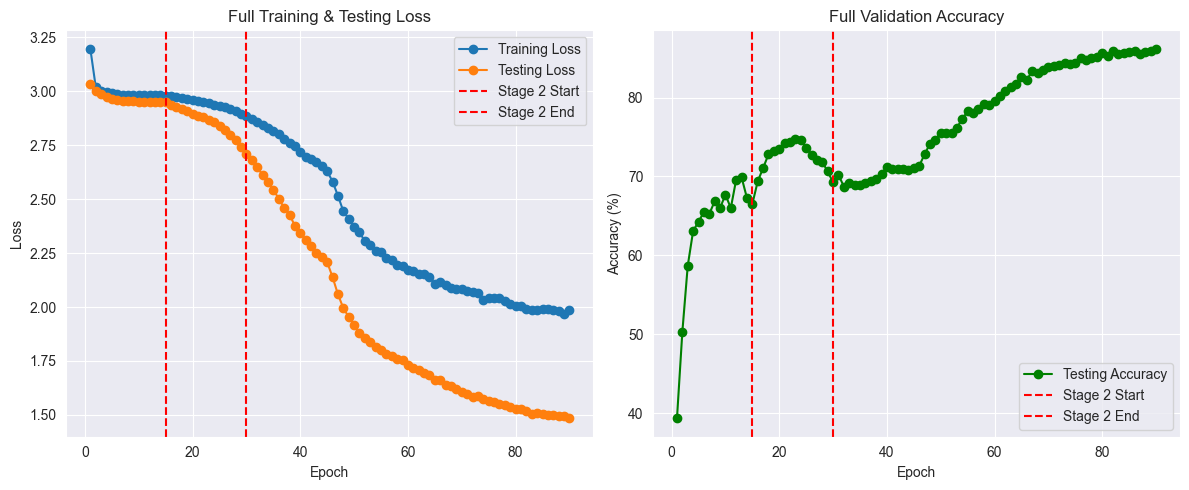

Data saved!


In [13]:
# import torch.optim as optim
#
# hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# classes = 6
# weight_decay = 1e-2
# num_margin = 3
#
# model = PestClassifierMobileNetV2(num_classes=classes, margin=num_margin).to(hardware)
# criterion = nn.CrossEntropyLoss()
#
# optimizer_p1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=weight_decay)
# model.unfreeze_last_block()
# model.unfreeze_before_last_block()
#
# result_1, accuracy_p1 = train_and_test(model=model, optimizer=optimizer_p1, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=15, device=hardware)
#
# save_historical_data(result_1)

In [15]:
import torch

allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")



--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------




Unfreezing the last convolutional block for fine-tuning...

Unfreezing the before last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 1/128 | Train Loss: 1.7819 | Test Loss: 1.7717 | Accuracy: 28.14% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 2: 100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


Epoch 2/128 | Train Loss: 1.7589 | Test Loss: 1.7491 | Accuracy: 31.14% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 3: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Epoch 3/128 | Train Loss: 1.7404 | Test Loss: 1.7302 | Accuracy: 33.49% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 4: 100%|██████████| 34/34 [00:04<00:00,  7.56it/s]


Epoch 4/128 | Train Loss: 1.7248 | Test Loss: 1.7158 | Accuracy: 35.04% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 5: 100%|██████████| 34/34 [00:12<00:00,  2.75it/s]


Epoch 5/128 | Train Loss: 1.7119 | Test Loss: 1.6998 | Accuracy: 36.96% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 6: 100%|██████████| 34/34 [00:07<00:00,  4.82it/s]


Epoch 6/128 | Train Loss: 1.7005 | Test Loss: 1.6877 | Accuracy: 38.13% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  6.43it/s]


Epoch 7/128 | Train Loss: 1.6910 | Test Loss: 1.6763 | Accuracy: 39.77% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 8: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Epoch 8/128 | Train Loss: 1.6826 | Test Loss: 1.6694 | Accuracy: 40.90% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 9: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Epoch 9/128 | Train Loss: 1.6745 | Test Loss: 1.6591 | Accuracy: 41.84% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 10: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch 10/128 | Train Loss: 1.6682 | Test Loss: 1.6492 | Accuracy: 42.40% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 11: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Epoch 11/128 | Train Loss: 1.6618 | Test Loss: 1.6441 | Accuracy: 44.04% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch 12/128 | Train Loss: 1.6566 | Test Loss: 1.6354 | Accuracy: 45.12% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch 13/128 | Train Loss: 1.6512 | Test Loss: 1.6301 | Accuracy: 46.67% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 14: 100%|██████████| 34/34 [00:04<00:00,  7.48it/s]


Epoch 14/128 | Train Loss: 1.6476 | Test Loss: 1.6232 | Accuracy: 48.03% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 15: 100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch 15/128 | Train Loss: 1.6439 | Test Loss: 1.6186 | Accuracy: 48.12% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 16: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 16/128 | Train Loss: 1.6409 | Test Loss: 1.6142 | Accuracy: 49.44% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 17: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 17/128 | Train Loss: 1.6364 | Test Loss: 1.6108 | Accuracy: 50.42% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 18: 100%|██████████| 34/34 [00:04<00:00,  7.63it/s]


Epoch 18/128 | Train Loss: 1.6338 | Test Loss: 1.6076 | Accuracy: 50.56% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 19: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s]


Epoch 19/128 | Train Loss: 1.6312 | Test Loss: 1.6016 | Accuracy: 52.44% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 20: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


Epoch 20/128 | Train Loss: 1.6299 | Test Loss: 1.6013 | Accuracy: 51.97% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 21: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch 21/128 | Train Loss: 1.6265 | Test Loss: 1.5978 | Accuracy: 51.88% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 22: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 22/128 | Train Loss: 1.6257 | Test Loss: 1.5958 | Accuracy: 52.95% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 23: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch 23/128 | Train Loss: 1.6239 | Test Loss: 1.5918 | Accuracy: 53.28% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 24: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


Epoch 24/128 | Train Loss: 1.6242 | Test Loss: 1.5904 | Accuracy: 54.08% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 25: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Epoch 25/128 | Train Loss: 1.6215 | Test Loss: 1.5891 | Accuracy: 55.21% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 26: 100%|██████████| 34/34 [00:04<00:00,  7.43it/s]


Epoch 26/128 | Train Loss: 1.6201 | Test Loss: 1.5868 | Accuracy: 55.02% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 27: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Epoch 27/128 | Train Loss: 1.6192 | Test Loss: 1.5852 | Accuracy: 55.63% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 28: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 28/128 | Train Loss: 1.6196 | Test Loss: 1.5865 | Accuracy: 55.63% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 29: 100%|██████████| 34/34 [00:04<00:00,  7.39it/s]


Epoch 29/128 | Train Loss: 1.6172 | Test Loss: 1.5854 | Accuracy: 55.91% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 30: 100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Epoch 30/128 | Train Loss: 1.6182 | Test Loss: 1.5826 | Accuracy: 56.19% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 31: 100%|██████████| 34/34 [00:05<00:00,  6.52it/s]


Epoch 31/128 | Train Loss: 1.6182 | Test Loss: 1.5817 | Accuracy: 56.47% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 32: 100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Epoch 32/128 | Train Loss: 1.6163 | Test Loss: 1.5814 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 33: 100%|██████████| 34/34 [00:04<00:00,  7.24it/s]


Epoch 33/128 | Train Loss: 1.6161 | Test Loss: 1.5806 | Accuracy: 56.14% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 34: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch 34/128 | Train Loss: 1.6183 | Test Loss: 1.5800 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 35: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Epoch 35/128 | Train Loss: 1.6161 | Test Loss: 1.5819 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 36: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Epoch 36/128 | Train Loss: 1.6160 | Test Loss: 1.5803 | Accuracy: 56.61% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 37: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch 37/128 | Train Loss: 1.6159 | Test Loss: 1.5810 | Accuracy: 55.91% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 38: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Epoch 38/128 | Train Loss: 1.6148 | Test Loss: 1.5777 | Accuracy: 56.33% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 39: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Epoch 39/128 | Train Loss: 1.6139 | Test Loss: 1.5797 | Accuracy: 57.04% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 40: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch 40/128 | Train Loss: 1.6150 | Test Loss: 1.5777 | Accuracy: 56.66% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 41: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch 41/128 | Train Loss: 1.6145 | Test Loss: 1.5789 | Accuracy: 56.75% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 42: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Epoch 42/128 | Train Loss: 1.6146 | Test Loss: 1.5786 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 43: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 43/128 | Train Loss: 1.6139 | Test Loss: 1.5794 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 44: 100%|██████████| 34/34 [00:04<00:00,  7.57it/s]


Epoch 44/128 | Train Loss: 1.6136 | Test Loss: 1.5785 | Accuracy: 57.50% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 45: 100%|██████████| 34/34 [00:04<00:00,  7.57it/s]


Epoch 45/128 | Train Loss: 1.6140 | Test Loss: 1.5768 | Accuracy: 57.50% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 46: 100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Epoch 46/128 | Train Loss: 1.6146 | Test Loss: 1.5791 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 47: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Epoch 47/128 | Train Loss: 1.6140 | Test Loss: 1.5778 | Accuracy: 57.69% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 48: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch 48/128 | Train Loss: 1.6129 | Test Loss: 1.5793 | Accuracy: 56.52% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 49: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 49/128 | Train Loss: 1.6141 | Test Loss: 1.5768 | Accuracy: 57.22% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 50: 100%|██████████| 34/34 [00:04<00:00,  7.58it/s]


Epoch 50/128 | Train Loss: 1.6127 | Test Loss: 1.5772 | Accuracy: 56.89% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 51: 100%|██████████| 34/34 [00:04<00:00,  7.60it/s]


Epoch 51/128 | Train Loss: 1.6145 | Test Loss: 1.5770 | Accuracy: 57.08% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 52: 100%|██████████| 34/34 [00:09<00:00,  3.67it/s]


Epoch 52/128 | Train Loss: 1.6138 | Test Loss: 1.5770 | Accuracy: 56.24% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 53: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Epoch 53/128 | Train Loss: 1.6131 | Test Loss: 1.5790 | Accuracy: 57.55% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 54: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 54/128 | Train Loss: 1.6141 | Test Loss: 1.5793 | Accuracy: 56.71% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 55: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


Epoch 55/128 | Train Loss: 1.6153 | Test Loss: 1.5771 | Accuracy: 57.83% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 56: 100%|██████████| 34/34 [00:07<00:00,  4.71it/s]


Epoch 56/128 | Train Loss: 1.6126 | Test Loss: 1.5786 | Accuracy: 57.27% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 57: 100%|██████████| 34/34 [00:04<00:00,  7.42it/s]


Epoch 57/128 | Train Loss: 1.6136 | Test Loss: 1.5775 | Accuracy: 57.55% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 58: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


Epoch 58/128 | Train Loss: 1.6146 | Test Loss: 1.5775 | Accuracy: 57.08% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 59: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]


Epoch 59/128 | Train Loss: 1.6143 | Test Loss: 1.5778 | Accuracy: 57.04% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 60: 100%|██████████| 34/34 [00:04<00:00,  7.37it/s]


Epoch 60/128 | Train Loss: 1.6134 | Test Loss: 1.5783 | Accuracy: 56.80% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 61: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


Epoch 61/128 | Train Loss: 1.6120 | Test Loss: 1.5781 | Accuracy: 56.61% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 62: 100%|██████████| 34/34 [00:04<00:00,  7.41it/s]


Epoch 62/128 | Train Loss: 1.6144 | Test Loss: 1.5769 | Accuracy: 57.22% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 63: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 63/128 | Train Loss: 1.6132 | Test Loss: 1.5771 | Accuracy: 58.02% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 64: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Epoch 64/128 | Train Loss: 1.6141 | Test Loss: 1.5780 | Accuracy: 56.29% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 65: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 65/128 | Train Loss: 1.6142 | Test Loss: 1.5762 | Accuracy: 57.18% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 66: 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]


Epoch 66/128 | Train Loss: 1.6145 | Test Loss: 1.5767 | Accuracy: 56.14% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 67: 100%|██████████| 34/34 [00:12<00:00,  2.72it/s]


Epoch 67/128 | Train Loss: 1.6143 | Test Loss: 1.5772 | Accuracy: 57.55% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 68: 100%|██████████| 34/34 [00:09<00:00,  3.50it/s]


Epoch 68/128 | Train Loss: 1.6131 | Test Loss: 1.5765 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 69: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 69/128 | Train Loss: 1.6129 | Test Loss: 1.5775 | Accuracy: 56.33% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 70: 100%|██████████| 34/34 [00:04<00:00,  7.47it/s]


Epoch 70/128 | Train Loss: 1.6131 | Test Loss: 1.5777 | Accuracy: 56.57% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 71: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Epoch 71/128 | Train Loss: 1.6142 | Test Loss: 1.5777 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 72: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Epoch 72/128 | Train Loss: 1.6134 | Test Loss: 1.5787 | Accuracy: 56.33% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 73: 100%|██████████| 34/34 [00:04<00:00,  7.33it/s]


Epoch 73/128 | Train Loss: 1.6128 | Test Loss: 1.5774 | Accuracy: 56.52% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 74: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Epoch 74/128 | Train Loss: 1.6139 | Test Loss: 1.5783 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 75: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Epoch 75/128 | Train Loss: 1.6141 | Test Loss: 1.5772 | Accuracy: 56.71% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 76: 100%|██████████| 34/34 [00:04<00:00,  7.35it/s]


Epoch 76/128 | Train Loss: 1.6143 | Test Loss: 1.5765 | Accuracy: 56.00% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 77: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 77/128 | Train Loss: 1.6134 | Test Loss: 1.5788 | Accuracy: 56.57% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 78: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 78/128 | Train Loss: 1.6140 | Test Loss: 1.5778 | Accuracy: 56.05% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 79: 100%|██████████| 34/34 [00:04<00:00,  7.35it/s]


Epoch 79/128 | Train Loss: 1.6139 | Test Loss: 1.5783 | Accuracy: 56.52% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 80: 100%|██████████| 34/34 [00:04<00:00,  7.54it/s]


Epoch 80/128 | Train Loss: 1.6133 | Test Loss: 1.5783 | Accuracy: 56.75% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 81: 100%|██████████| 34/34 [00:04<00:00,  7.36it/s]


Epoch 81/128 | Train Loss: 1.6149 | Test Loss: 1.5779 | Accuracy: 57.08% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 82: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Epoch 82/128 | Train Loss: 1.6150 | Test Loss: 1.5783 | Accuracy: 56.43% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 83: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 83/128 | Train Loss: 1.6136 | Test Loss: 1.5751 | Accuracy: 56.75% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 84: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch 84/128 | Train Loss: 1.6144 | Test Loss: 1.5780 | Accuracy: 57.13% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 85: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Epoch 85/128 | Train Loss: 1.6125 | Test Loss: 1.5789 | Accuracy: 57.13% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 86: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 86/128 | Train Loss: 1.6131 | Test Loss: 1.5764 | Accuracy: 57.79% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 87: 100%|██████████| 34/34 [00:04<00:00,  7.55it/s]


Epoch 87/128 | Train Loss: 1.6141 | Test Loss: 1.5768 | Accuracy: 56.38% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 88: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]


Epoch 88/128 | Train Loss: 1.6130 | Test Loss: 1.5772 | Accuracy: 57.36% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 89: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch 89/128 | Train Loss: 1.6140 | Test Loss: 1.5774 | Accuracy: 56.43% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 90: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


Epoch 90/128 | Train Loss: 1.6128 | Test Loss: 1.5760 | Accuracy: 57.04% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 91: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Epoch 91/128 | Train Loss: 1.6148 | Test Loss: 1.5778 | Accuracy: 55.72% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 92: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 92/128 | Train Loss: 1.6135 | Test Loss: 1.5762 | Accuracy: 56.75% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 93: 100%|██████████| 34/34 [00:04<00:00,  7.47it/s]


Epoch 93/128 | Train Loss: 1.6149 | Test Loss: 1.5763 | Accuracy: 57.83% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 94: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Epoch 94/128 | Train Loss: 1.6130 | Test Loss: 1.5769 | Accuracy: 56.75% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 95: 100%|██████████| 34/34 [00:04<00:00,  7.39it/s]


Epoch 95/128 | Train Loss: 1.6145 | Test Loss: 1.5784 | Accuracy: 55.86% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 96: 100%|██████████| 34/34 [00:05<00:00,  6.49it/s]


Epoch 96/128 | Train Loss: 1.6153 | Test Loss: 1.5766 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 97: 100%|██████████| 34/34 [00:04<00:00,  7.34it/s]


Epoch 97/128 | Train Loss: 1.6129 | Test Loss: 1.5775 | Accuracy: 56.29% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 98: 100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Epoch 98/128 | Train Loss: 1.6144 | Test Loss: 1.5782 | Accuracy: 56.66% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 99: 100%|██████████| 34/34 [00:05<00:00,  6.61it/s]


Epoch 99/128 | Train Loss: 1.6131 | Test Loss: 1.5771 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 100: 100%|██████████| 34/34 [00:05<00:00,  6.67it/s]


Epoch 100/128 | Train Loss: 1.6149 | Test Loss: 1.5792 | Accuracy: 56.71% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 101: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s]


Epoch 101/128 | Train Loss: 1.6142 | Test Loss: 1.5782 | Accuracy: 56.80% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 102: 100%|██████████| 34/34 [00:13<00:00,  2.61it/s]


Epoch 102/128 | Train Loss: 1.6150 | Test Loss: 1.5784 | Accuracy: 57.22% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 103: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s]


Epoch 103/128 | Train Loss: 1.6140 | Test Loss: 1.5789 | Accuracy: 55.68% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 104: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 104/128 | Train Loss: 1.6140 | Test Loss: 1.5787 | Accuracy: 55.77% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 105: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 105/128 | Train Loss: 1.6145 | Test Loss: 1.5770 | Accuracy: 56.61% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 106: 100%|██████████| 34/34 [00:04<00:00,  6.94it/s]


Epoch 106/128 | Train Loss: 1.6131 | Test Loss: 1.5768 | Accuracy: 57.04% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 107: 100%|██████████| 34/34 [00:12<00:00,  2.77it/s]


Epoch 107/128 | Train Loss: 1.6144 | Test Loss: 1.5765 | Accuracy: 56.66% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 108: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Epoch 108/128 | Train Loss: 1.6149 | Test Loss: 1.5771 | Accuracy: 56.89% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 109: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Epoch 109/128 | Train Loss: 1.6136 | Test Loss: 1.5766 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 110: 100%|██████████| 34/34 [00:05<00:00,  6.75it/s]


Epoch 110/128 | Train Loss: 1.6150 | Test Loss: 1.5789 | Accuracy: 55.82% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 111: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Epoch 111/128 | Train Loss: 1.6140 | Test Loss: 1.5778 | Accuracy: 56.80% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 112: 100%|██████████| 34/34 [00:04<00:00,  7.04it/s]


Epoch 112/128 | Train Loss: 1.6140 | Test Loss: 1.5787 | Accuracy: 57.13% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 113: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 113/128 | Train Loss: 1.6137 | Test Loss: 1.5783 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 114: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 114/128 | Train Loss: 1.6140 | Test Loss: 1.5770 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 115: 100%|██████████| 34/34 [00:05<00:00,  6.46it/s]


Epoch 115/128 | Train Loss: 1.6151 | Test Loss: 1.5782 | Accuracy: 56.85% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 116: 100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


Epoch 116/128 | Train Loss: 1.6139 | Test Loss: 1.5774 | Accuracy: 56.05% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 117: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Epoch 117/128 | Train Loss: 1.6148 | Test Loss: 1.5767 | Accuracy: 56.89% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 118: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Epoch 118/128 | Train Loss: 1.6147 | Test Loss: 1.5801 | Accuracy: 56.47% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 119: 100%|██████████| 34/34 [00:04<00:00,  7.14it/s]


Epoch 119/128 | Train Loss: 1.6133 | Test Loss: 1.5787 | Accuracy: 56.71% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 120: 100%|██████████| 34/34 [00:04<00:00,  6.99it/s]


Epoch 120/128 | Train Loss: 1.6142 | Test Loss: 1.5784 | Accuracy: 56.80% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 121: 100%|██████████| 34/34 [00:05<00:00,  6.74it/s]


Epoch 121/128 | Train Loss: 1.6141 | Test Loss: 1.5779 | Accuracy: 56.14% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 122: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 122/128 | Train Loss: 1.6126 | Test Loss: 1.5790 | Accuracy: 57.27% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 123: 100%|██████████| 34/34 [00:04<00:00,  7.22it/s]


Epoch 123/128 | Train Loss: 1.6124 | Test Loss: 1.5791 | Accuracy: 56.99% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 124: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Epoch 124/128 | Train Loss: 1.6144 | Test Loss: 1.5792 | Accuracy: 57.22% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 125: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 125/128 | Train Loss: 1.6143 | Test Loss: 1.5785 | Accuracy: 57.32% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 126: 100%|██████████| 34/34 [00:05<00:00,  6.73it/s]


Epoch 126/128 | Train Loss: 1.6132 | Test Loss: 1.5784 | Accuracy: 56.61% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 127: 100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Epoch 127/128 | Train Loss: 1.6145 | Test Loss: 1.5776 | Accuracy: 57.32% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB


Test epoch: 128: 100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


Epoch 128/128 | Train Loss: 1.6153 | Test Loss: 1.5778 | Accuracy: 56.66% | GPU Memory (Alloc/Reserved): 0.07/1.852 GB
Phase done!


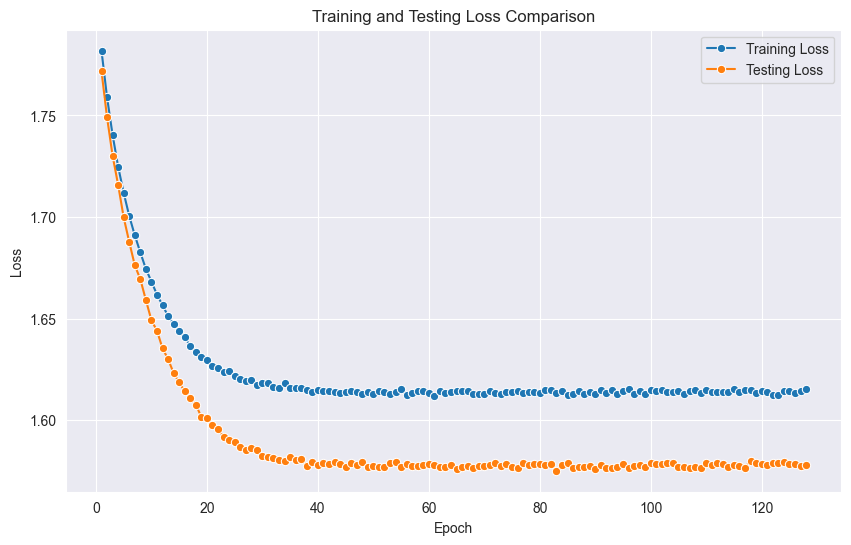

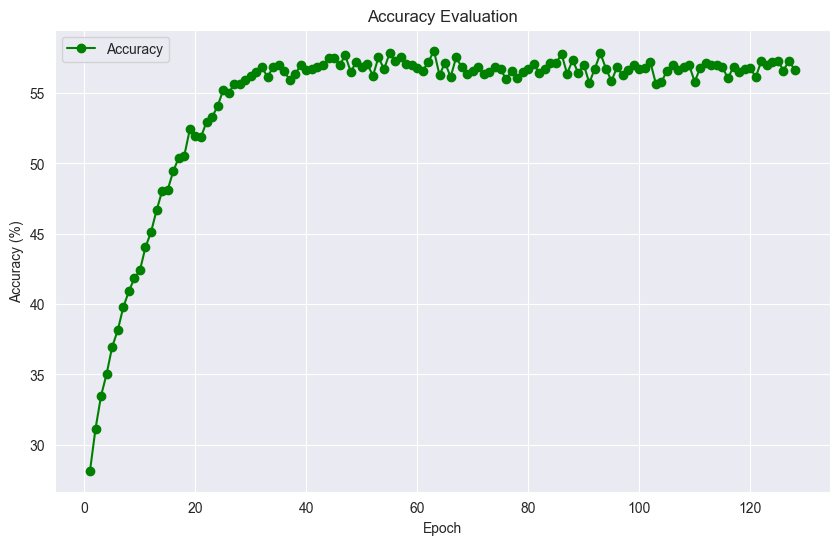

Creating new historical data...
Historical data saved successfully!


In [52]:
import torch.optim as optim

hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = 6
weight_decay = 1e-2
num_margin = 3

model = PestClassifierMobileNetV2(num_classes=classes, margin=num_margin).to(hardware)
criterion = nn.CrossEntropyLoss()

optimizer_p1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=weight_decay)
model.unfreeze_last_block()
model.unfreeze_before_last_block()

result_1, accuracy_p1 = train_and_test(model=model, optimizer=optimizer_p1, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=128, device=hardware)

plot_training_result(result_1)
plot_accuracy(result_1)
save_historical_data(result_1)

In [13]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    augmented = transform(image=image_np)
    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(image_tensor, labels=None)

        probabilities = F.softmax(result, dim=1)

        confidence, predicted_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_index.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.squeeze().cpu().numpy()


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.03it/s]


Epoch 1/16 | Train Loss: 3.1851 | Test Loss: 3.0164 | Accuracy: 49.95% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 2/16 | Train Loss: 3.0014 | Test Loss: 2.9752 | Accuracy: 60.23% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]


Epoch 3/16 | Train Loss: 2.9768 | Test Loss: 2.9540 | Accuracy: 65.57% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 4/16 | Train Loss: 2.9622 | Test Loss: 2.9451 | Accuracy: 67.07% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 5/16 | Train Loss: 2.9540 | Test Loss: 2.9337 | Accuracy: 68.48% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 6/16 | Train Loss: 2.9523 | Test Loss: 2.9304 | Accuracy: 69.32% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 7/16 | Train Loss: 2.9489 | Test Loss: 2.9283 | Accuracy: 68.90% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 8/16 | Train Loss: 2.9481 | Test Loss: 2.9272 | Accuracy: 70.73% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 9/16 | Train Loss: 2.9473 | Test Loss: 2.9253 | Accuracy: 69.93% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.11it/s]


Epoch 10/16 | Train Loss: 2.9477 | Test Loss: 2.9277 | Accuracy: 68.90% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:07<00:00,  4.71it/s]


Epoch 11/16 | Train Loss: 2.9472 | Test Loss: 2.9289 | Accuracy: 70.12% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 12/16 | Train Loss: 2.9478 | Test Loss: 2.9260 | Accuracy: 70.64% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 13/16 | Train Loss: 2.9473 | Test Loss: 2.9255 | Accuracy: 69.61% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 14/16 | Train Loss: 2.9465 | Test Loss: 2.9258 | Accuracy: 69.18% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:05<00:00,  5.70it/s]


Epoch 15/16 | Train Loss: 2.9482 | Test Loss: 2.9306 | Accuracy: 70.54% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 16/16 | Train Loss: 2.9472 | Test Loss: 2.9279 | Accuracy: 70.87% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB
Phase done!

Unfreezing the last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 1/32 | Train Loss: 2.9402 | Test Loss: 2.9064 | Accuracy: 73.26% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 2/32 | Train Loss: 2.9257 | Test Loss: 2.8885 | Accuracy: 74.81% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 3/32 | Train Loss: 2.9118 | Test Loss: 2.8715 | Accuracy: 76.08% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]


Epoch 4/32 | Train Loss: 2.8960 | Test Loss: 2.8524 | Accuracy: 76.36% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 5/32 | Train Loss: 2.8802 | Test Loss: 2.8263 | Accuracy: 76.03% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]


Epoch 6/32 | Train Loss: 2.8580 | Test Loss: 2.7889 | Accuracy: 75.70% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Epoch 7/32 | Train Loss: 2.8278 | Test Loss: 2.7390 | Accuracy: 74.20% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 8/32 | Train Loss: 2.7905 | Test Loss: 2.6830 | Accuracy: 73.59% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 9/32 | Train Loss: 2.7425 | Test Loss: 2.6123 | Accuracy: 72.61% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 10/32 | Train Loss: 2.6959 | Test Loss: 2.5491 | Accuracy: 72.94% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 11/32 | Train Loss: 2.6486 | Test Loss: 2.4707 | Accuracy: 72.42% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 12/32 | Train Loss: 2.6041 | Test Loss: 2.4013 | Accuracy: 72.80% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 13/32 | Train Loss: 2.5603 | Test Loss: 2.3561 | Accuracy: 72.70% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 14/32 | Train Loss: 2.5067 | Test Loss: 2.2913 | Accuracy: 73.73% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.44it/s]


Epoch 15/32 | Train Loss: 2.4628 | Test Loss: 2.2401 | Accuracy: 73.64% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.50it/s]


Epoch 16/32 | Train Loss: 2.4294 | Test Loss: 2.2018 | Accuracy: 74.02% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.07it/s]


Epoch 17/32 | Train Loss: 2.3940 | Test Loss: 2.1471 | Accuracy: 74.02% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 18: 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]


Epoch 18/32 | Train Loss: 2.3510 | Test Loss: 2.1196 | Accuracy: 73.92% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 19: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 19/32 | Train Loss: 2.3224 | Test Loss: 2.0965 | Accuracy: 74.06% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 20: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 20/32 | Train Loss: 2.3026 | Test Loss: 2.0625 | Accuracy: 74.62% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 21: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 21/32 | Train Loss: 2.2765 | Test Loss: 2.0331 | Accuracy: 74.58% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 22: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch 22/32 | Train Loss: 2.2466 | Test Loss: 2.0244 | Accuracy: 75.28% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 23: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Epoch 23/32 | Train Loss: 2.2379 | Test Loss: 1.9990 | Accuracy: 75.19% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 24: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 24/32 | Train Loss: 2.2039 | Test Loss: 1.9718 | Accuracy: 75.28% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 25: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 25/32 | Train Loss: 2.1965 | Test Loss: 1.9573 | Accuracy: 75.80% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 26: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 26/32 | Train Loss: 2.1665 | Test Loss: 1.9377 | Accuracy: 76.27% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 27: 100%|██████████| 34/34 [00:05<00:00,  5.76it/s]


Epoch 27/32 | Train Loss: 2.1564 | Test Loss: 1.9222 | Accuracy: 76.50% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 28: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch 28/32 | Train Loss: 2.1455 | Test Loss: 1.9044 | Accuracy: 76.78% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 29: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 29/32 | Train Loss: 2.1252 | Test Loss: 1.8949 | Accuracy: 76.92% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 30: 100%|██████████| 34/34 [00:05<00:00,  5.87it/s]


Epoch 30/32 | Train Loss: 2.1124 | Test Loss: 1.8855 | Accuracy: 77.02% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 31: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]


Epoch 31/32 | Train Loss: 2.0950 | Test Loss: 1.8707 | Accuracy: 77.30% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 32: 100%|██████████| 34/34 [00:06<00:00,  5.55it/s]


Epoch 32/32 | Train Loss: 2.0793 | Test Loss: 1.8563 | Accuracy: 77.44% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB
Phase done!

Unfreezing the before last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]


Epoch 1/48 | Train Loss: 2.0578 | Test Loss: 1.8329 | Accuracy: 77.53% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 2/48 | Train Loss: 2.0465 | Test Loss: 1.8252 | Accuracy: 77.67% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 3/48 | Train Loss: 2.0283 | Test Loss: 1.8177 | Accuracy: 77.63% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.83it/s]


Epoch 4/48 | Train Loss: 2.0170 | Test Loss: 1.8024 | Accuracy: 77.81% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 5/48 | Train Loss: 1.9983 | Test Loss: 1.8018 | Accuracy: 78.28% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 6/48 | Train Loss: 2.0007 | Test Loss: 1.7914 | Accuracy: 78.05% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 7/48 | Train Loss: 2.0044 | Test Loss: 1.7787 | Accuracy: 78.24% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Epoch 8/48 | Train Loss: 1.9831 | Test Loss: 1.7706 | Accuracy: 78.47% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]


Epoch 9/48 | Train Loss: 1.9657 | Test Loss: 1.7617 | Accuracy: 78.47% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:05<00:00,  5.71it/s]


Epoch 10/48 | Train Loss: 1.9751 | Test Loss: 1.7504 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:05<00:00,  5.86it/s]


Epoch 11/48 | Train Loss: 1.9650 | Test Loss: 1.7478 | Accuracy: 79.17% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:06<00:00,  5.40it/s]


Epoch 12/48 | Train Loss: 1.9468 | Test Loss: 1.7399 | Accuracy: 78.80% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 13/48 | Train Loss: 1.9410 | Test Loss: 1.7359 | Accuracy: 79.27% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


Epoch 14/48 | Train Loss: 1.9381 | Test Loss: 1.7271 | Accuracy: 79.22% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 15/48 | Train Loss: 1.9426 | Test Loss: 1.7187 | Accuracy: 79.08% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:06<00:00,  5.44it/s]


Epoch 16/48 | Train Loss: 1.9276 | Test Loss: 1.7115 | Accuracy: 79.46% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.53it/s]


Epoch 17/48 | Train Loss: 1.9332 | Test Loss: 1.7096 | Accuracy: 79.36% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 18/48 | Train Loss: 1.9227 | Test Loss: 1.6976 | Accuracy: 79.55% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 19/48 | Train Loss: 1.9103 | Test Loss: 1.6956 | Accuracy: 79.46% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Epoch 20/48 | Train Loss: 1.9024 | Test Loss: 1.6947 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.28it/s]


Epoch 21/48 | Train Loss: 1.9062 | Test Loss: 1.6894 | Accuracy: 79.88% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 22: 100%|██████████| 34/34 [00:06<00:00,  5.48it/s]


Epoch 22/48 | Train Loss: 1.9105 | Test Loss: 1.6819 | Accuracy: 79.60% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.45it/s]


Epoch 23/48 | Train Loss: 1.9008 | Test Loss: 1.6816 | Accuracy: 79.88% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.46it/s]


Epoch 24/48 | Train Loss: 1.9041 | Test Loss: 1.6808 | Accuracy: 79.69% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch 25/48 | Train Loss: 1.8940 | Test Loss: 1.6774 | Accuracy: 79.97% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.45it/s]


Epoch 26/48 | Train Loss: 1.8932 | Test Loss: 1.6715 | Accuracy: 80.11% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.51it/s]


Epoch 27/48 | Train Loss: 1.8929 | Test Loss: 1.6720 | Accuracy: 80.21% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 28: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 28/48 | Train Loss: 1.8535 | Test Loss: 1.6606 | Accuracy: 80.02% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 29: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 29/48 | Train Loss: 1.8766 | Test Loss: 1.6644 | Accuracy: 79.97% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 30: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 30/48 | Train Loss: 1.8793 | Test Loss: 1.6638 | Accuracy: 80.30% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 31: 100%|██████████| 34/34 [00:06<00:00,  5.37it/s]


Epoch 31/48 | Train Loss: 1.8713 | Test Loss: 1.6605 | Accuracy: 80.07% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 32: 100%|██████████| 34/34 [00:06<00:00,  5.40it/s]


Epoch 32/48 | Train Loss: 1.8847 | Test Loss: 1.6658 | Accuracy: 80.16% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 33: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 33/48 | Train Loss: 1.8516 | Test Loss: 1.6521 | Accuracy: 80.49% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 34: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 34/48 | Train Loss: 1.8678 | Test Loss: 1.6523 | Accuracy: 80.39% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 35: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 35/48 | Train Loss: 1.8546 | Test Loss: 1.6518 | Accuracy: 80.49% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 36: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 36/48 | Train Loss: 1.8598 | Test Loss: 1.6513 | Accuracy: 80.77% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 37: 100%|██████████| 34/34 [00:11<00:00,  2.96it/s]


Epoch 37/48 | Train Loss: 1.8620 | Test Loss: 1.6455 | Accuracy: 80.11% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 38: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]


Epoch 38/48 | Train Loss: 1.8616 | Test Loss: 1.6436 | Accuracy: 80.07% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 39: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 39/48 | Train Loss: 1.8498 | Test Loss: 1.6489 | Accuracy: 80.02% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 40: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s]


Epoch 40/48 | Train Loss: 1.8703 | Test Loss: 1.6507 | Accuracy: 80.35% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 41: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]


Epoch 41/48 | Train Loss: 1.8304 | Test Loss: 1.6403 | Accuracy: 80.63% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 42: 100%|██████████| 34/34 [00:10<00:00,  3.37it/s]


Epoch 42/48 | Train Loss: 1.8351 | Test Loss: 1.6362 | Accuracy: 80.82% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 43: 100%|██████████| 34/34 [00:10<00:00,  3.28it/s]


Epoch 43/48 | Train Loss: 1.8485 | Test Loss: 1.6390 | Accuracy: 80.53% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 44: 100%|██████████| 34/34 [00:10<00:00,  3.10it/s]


Epoch 44/48 | Train Loss: 1.8585 | Test Loss: 1.6289 | Accuracy: 80.49% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 45: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


Epoch 45/48 | Train Loss: 1.8463 | Test Loss: 1.6289 | Accuracy: 80.82% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 46: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 46/48 | Train Loss: 1.8327 | Test Loss: 1.6283 | Accuracy: 80.30% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 47: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 47/48 | Train Loss: 1.8384 | Test Loss: 1.6312 | Accuracy: 80.02% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 48: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 48/48 | Train Loss: 1.8320 | Test Loss: 1.6330 | Accuracy: 80.91% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB
Phase done!

Unfreezing the third last convolutional block for fine-tuning...


Test epoch: 1: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 1/64 | Train Loss: 1.8300 | Test Loss: 1.6360 | Accuracy: 80.35% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 2: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 2/64 | Train Loss: 1.8335 | Test Loss: 1.6229 | Accuracy: 80.53% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 3: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 3/64 | Train Loss: 1.8235 | Test Loss: 1.6261 | Accuracy: 80.39% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 4: 100%|██████████| 34/34 [00:05<00:00,  5.69it/s]


Epoch 4/64 | Train Loss: 1.8242 | Test Loss: 1.6156 | Accuracy: 80.39% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 5: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 5/64 | Train Loss: 1.8102 | Test Loss: 1.6258 | Accuracy: 80.49% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 6: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 6/64 | Train Loss: 1.8269 | Test Loss: 1.6160 | Accuracy: 80.63% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 7: 100%|██████████| 34/34 [00:06<00:00,  5.30it/s]


Epoch 7/64 | Train Loss: 1.8323 | Test Loss: 1.6174 | Accuracy: 80.72% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 8: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]


Epoch 8/64 | Train Loss: 1.8304 | Test Loss: 1.6149 | Accuracy: 80.68% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 9: 100%|██████████| 34/34 [00:06<00:00,  5.15it/s]


Epoch 9/64 | Train Loss: 1.8183 | Test Loss: 1.6164 | Accuracy: 80.58% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 10: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Epoch 10/64 | Train Loss: 1.8131 | Test Loss: 1.6136 | Accuracy: 80.72% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 11: 100%|██████████| 34/34 [00:06<00:00,  5.62it/s]


Epoch 11/64 | Train Loss: 1.8215 | Test Loss: 1.6153 | Accuracy: 80.96% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 12: 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]


Epoch 12/64 | Train Loss: 1.8137 | Test Loss: 1.6213 | Accuracy: 80.86% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 13: 100%|██████████| 34/34 [00:06<00:00,  5.40it/s]


Epoch 13/64 | Train Loss: 1.8120 | Test Loss: 1.6133 | Accuracy: 80.58% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 14: 100%|██████████| 34/34 [00:05<00:00,  5.67it/s]


Epoch 14/64 | Train Loss: 1.8331 | Test Loss: 1.6127 | Accuracy: 81.00% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 15: 100%|██████████| 34/34 [00:07<00:00,  4.38it/s]


Epoch 15/64 | Train Loss: 1.8170 | Test Loss: 1.6163 | Accuracy: 80.86% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 16: 100%|██████████| 34/34 [00:07<00:00,  4.69it/s]


Epoch 16/64 | Train Loss: 1.8195 | Test Loss: 1.6123 | Accuracy: 81.19% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 17: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Epoch 17/64 | Train Loss: 1.8069 | Test Loss: 1.6082 | Accuracy: 81.19% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 18: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 18/64 | Train Loss: 1.8069 | Test Loss: 1.6125 | Accuracy: 81.24% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 19: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 19/64 | Train Loss: 1.8045 | Test Loss: 1.6047 | Accuracy: 81.19% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 20: 100%|██████████| 34/34 [00:06<00:00,  5.63it/s]


Epoch 20/64 | Train Loss: 1.8205 | Test Loss: 1.6111 | Accuracy: 81.14% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 21: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Epoch 21/64 | Train Loss: 1.8128 | Test Loss: 1.6017 | Accuracy: 80.91% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 22: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Epoch 22/64 | Train Loss: 1.8040 | Test Loss: 1.6041 | Accuracy: 81.43% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 23: 100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Epoch 23/64 | Train Loss: 1.7981 | Test Loss: 1.6036 | Accuracy: 81.29% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 24: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 24/64 | Train Loss: 1.7966 | Test Loss: 1.5997 | Accuracy: 81.47% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 25: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 25/64 | Train Loss: 1.8050 | Test Loss: 1.6069 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 26: 100%|██████████| 34/34 [00:06<00:00,  5.57it/s]


Epoch 26/64 | Train Loss: 1.8007 | Test Loss: 1.5977 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 27: 100%|██████████| 34/34 [00:06<00:00,  5.32it/s]


Epoch 27/64 | Train Loss: 1.7983 | Test Loss: 1.6009 | Accuracy: 81.47% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 28: 100%|██████████| 34/34 [00:11<00:00,  2.98it/s]


Epoch 28/64 | Train Loss: 1.8017 | Test Loss: 1.5934 | Accuracy: 81.80% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 29: 100%|██████████| 34/34 [00:12<00:00,  2.66it/s]


Epoch 29/64 | Train Loss: 1.8038 | Test Loss: 1.6048 | Accuracy: 81.47% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 30: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]


Epoch 30/64 | Train Loss: 1.8034 | Test Loss: 1.5886 | Accuracy: 81.85% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 31: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]


Epoch 31/64 | Train Loss: 1.7950 | Test Loss: 1.6075 | Accuracy: 81.33% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 32: 100%|██████████| 34/34 [00:06<00:00,  4.94it/s]


Epoch 32/64 | Train Loss: 1.7951 | Test Loss: 1.5935 | Accuracy: 81.75% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 33: 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]


Epoch 33/64 | Train Loss: 1.7919 | Test Loss: 1.5906 | Accuracy: 81.61% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 34: 100%|██████████| 34/34 [00:06<00:00,  5.41it/s]


Epoch 34/64 | Train Loss: 1.8146 | Test Loss: 1.5953 | Accuracy: 81.66% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 35: 100%|██████████| 34/34 [00:13<00:00,  2.59it/s]


Epoch 35/64 | Train Loss: 1.8006 | Test Loss: 1.5924 | Accuracy: 81.80% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 36: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 36/64 | Train Loss: 1.8012 | Test Loss: 1.5841 | Accuracy: 81.89% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 37: 100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


Epoch 37/64 | Train Loss: 1.7840 | Test Loss: 1.5926 | Accuracy: 81.89% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 38: 100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


Epoch 38/64 | Train Loss: 1.7810 | Test Loss: 1.5896 | Accuracy: 81.85% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 39: 100%|██████████| 34/34 [00:06<00:00,  5.49it/s]


Epoch 39/64 | Train Loss: 1.7944 | Test Loss: 1.5842 | Accuracy: 81.94% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 40: 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]


Epoch 40/64 | Train Loss: 1.7901 | Test Loss: 1.5862 | Accuracy: 81.75% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 41: 100%|██████████| 34/34 [00:12<00:00,  2.68it/s]


Epoch 41/64 | Train Loss: 1.7857 | Test Loss: 1.5884 | Accuracy: 82.18% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 42: 100%|██████████| 34/34 [00:10<00:00,  3.20it/s]


Epoch 42/64 | Train Loss: 1.7989 | Test Loss: 1.5920 | Accuracy: 82.27% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 43: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


Epoch 43/64 | Train Loss: 1.7868 | Test Loss: 1.5940 | Accuracy: 82.08% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 44: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s]


Epoch 44/64 | Train Loss: 1.7769 | Test Loss: 1.5876 | Accuracy: 81.71% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 45: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 45/64 | Train Loss: 1.7890 | Test Loss: 1.5818 | Accuracy: 81.66% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 46: 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]


Epoch 46/64 | Train Loss: 1.7911 | Test Loss: 1.5890 | Accuracy: 81.66% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 47: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 47/64 | Train Loss: 1.7802 | Test Loss: 1.5837 | Accuracy: 81.80% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 48: 100%|██████████| 34/34 [00:06<00:00,  5.64it/s]


Epoch 48/64 | Train Loss: 1.7805 | Test Loss: 1.5829 | Accuracy: 81.94% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 49: 100%|██████████| 34/34 [00:05<00:00,  5.84it/s]


Epoch 49/64 | Train Loss: 1.7831 | Test Loss: 1.5830 | Accuracy: 82.13% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 50: 100%|██████████| 34/34 [00:10<00:00,  3.18it/s]


Epoch 50/64 | Train Loss: 1.7913 | Test Loss: 1.5831 | Accuracy: 81.89% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 51: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 51/64 | Train Loss: 1.7705 | Test Loss: 1.5762 | Accuracy: 82.22% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 52: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 52/64 | Train Loss: 1.7944 | Test Loss: 1.5848 | Accuracy: 81.99% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 53: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch 53/64 | Train Loss: 1.7829 | Test Loss: 1.5744 | Accuracy: 81.99% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 54: 100%|██████████| 34/34 [00:05<00:00,  5.72it/s]


Epoch 54/64 | Train Loss: 1.7811 | Test Loss: 1.5729 | Accuracy: 81.99% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 55: 100%|██████████| 34/34 [00:05<00:00,  5.80it/s]


Epoch 55/64 | Train Loss: 1.7924 | Test Loss: 1.5811 | Accuracy: 81.99% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 56: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Epoch 56/64 | Train Loss: 1.7842 | Test Loss: 1.5849 | Accuracy: 81.99% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 57: 100%|██████████| 34/34 [00:10<00:00,  3.12it/s]


Epoch 57/64 | Train Loss: 1.7816 | Test Loss: 1.5742 | Accuracy: 82.41% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 58: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


Epoch 58/64 | Train Loss: 1.7747 | Test Loss: 1.5804 | Accuracy: 82.13% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 59: 100%|██████████| 34/34 [00:06<00:00,  5.29it/s]


Epoch 59/64 | Train Loss: 1.7724 | Test Loss: 1.5784 | Accuracy: 82.18% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 60: 100%|██████████| 34/34 [00:05<00:00,  5.77it/s]


Epoch 60/64 | Train Loss: 1.7946 | Test Loss: 1.5736 | Accuracy: 82.18% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 61: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 61/64 | Train Loss: 1.7778 | Test Loss: 1.5783 | Accuracy: 81.85% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 62: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Epoch 62/64 | Train Loss: 1.7706 | Test Loss: 1.5764 | Accuracy: 82.08% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 63: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s]


Epoch 63/64 | Train Loss: 1.7882 | Test Loss: 1.5889 | Accuracy: 81.47% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB


Test epoch: 64: 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]


Epoch 64/64 | Train Loss: 1.7753 | Test Loss: 1.5753 | Accuracy: 81.99% | GPU Memory (Alloc/Reserved): 0.11/1.83 GB
Phase done!


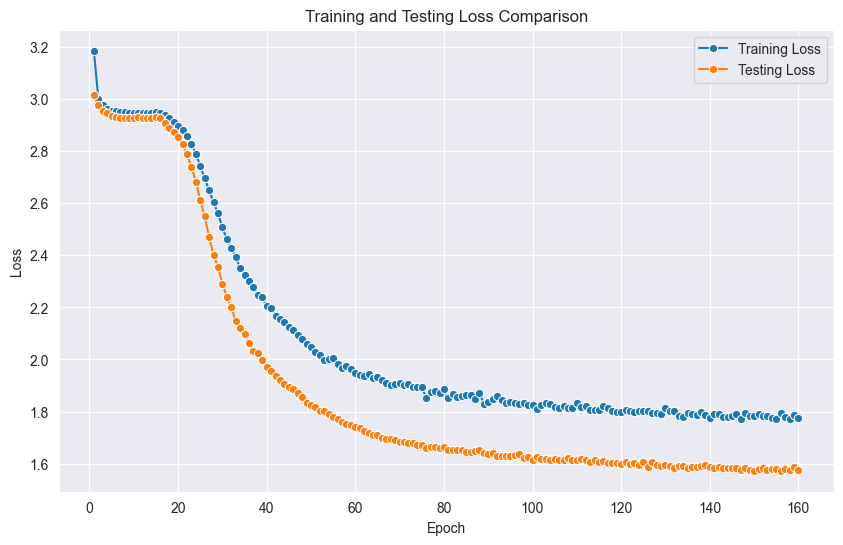

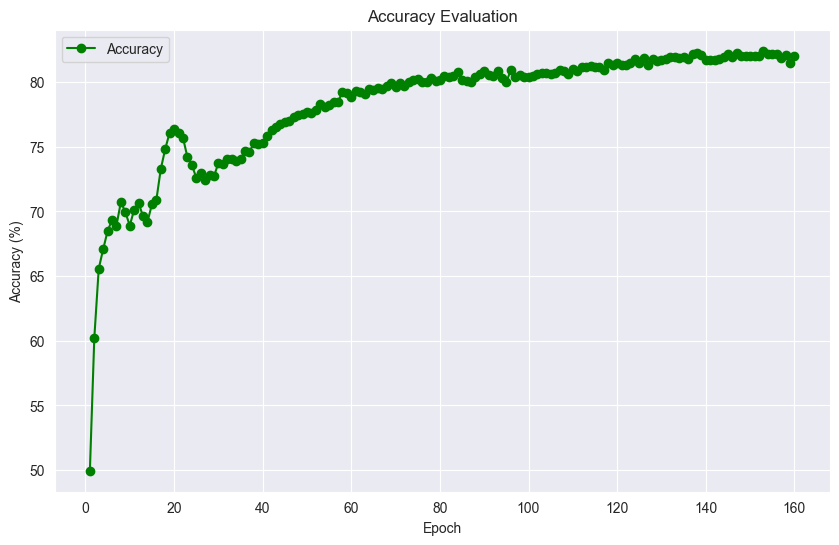

Creating new historical data...
Historical data saved successfully!


In [18]:
import torch.optim as optim

hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = 6
weight_decay = 1e-2
num_margin = 3

model = PestClassifierMobileNetV2(num_classes=classes, margin=num_margin).to(hardware)
criterion = nn.CrossEntropyLoss()

optimizer_1 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=weight_decay)

result_1, accuracy_p1 = train_and_test(model=model, optimizer=optimizer_1, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=16, device=hardware)

model.unfreeze_last_block()
optimizer_2 = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=weight_decay)

result_2, accuracy_p2 = train_and_test(model=model, optimizer=optimizer_2, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=32, device=hardware)

model.unfreeze_before_last_block()

result_3, accuracy_p3 = train_and_test(model=model, optimizer=optimizer_2, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=48, device=hardware)

model.unfreeze_third_last_inverse_residual()

result_4, accuracy_p4 = train_and_test(model=model, optimizer=optimizer_2, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)

plot_training_result(result_1, result_2, result_3, result_4)
plot_accuracy(result_1, result_2, result_3, result_4)
save_historical_data(result_1, result_2, result_3, result_4)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad:

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input, labels=None)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_true = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(f"\nAccuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    return y_true, y_true

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


In [22]:
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



<h2> Prediction comparison </h2>

In [36]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names), margin=4)
model_inference.load_state_dict(torch.load('models/v2/Advance/MobileNetV2_rice_pest_classificationV5.pt', map_location=hardware))
image_path = 'datasets/val/green-leafhopper/9 (352).jpg'

pest, confidence_score, all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Confidence scores: {all_scores}")

The predicted pest is: green-leafhopper
Confidence: 35.80%
Confidence scores: [0.14487416 0.3580104  0.0849735  0.13699296 0.13883169 0.13631725]


In [35]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names), margin=4)
model_inference.load_state_dict(torch.load('models/v2/Advance/MobileNetV2_rice_pest_classificationV3.pth', map_location=hardware))
image_path =  'datasets/val/green-leafhopper/9 (352).jpg'

pest, confidence_score, all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Confidence scores: {all_scores}")

The predicted pest is: green-leafhopper
Confidence: 35.60%
Confidence scores: [0.1437338  0.35601172 0.08399493 0.13710716 0.14059219 0.1385602 ]


In [ ]:
print(model.features[0])

In [94]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

# print(model.classifier[1])
print(model.features[-1])
print("qweqwe")
print(model.features[-2])
print("asdasd")

print(model.parameters)

Conv2dNormActivation(
  (0): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU6(inplace=True)
)
qweqwe
InvertedResidual(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(960, 960, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=960, bias=False)
      (1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Conv2d(960, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
asdasd
<bound method Module.parameters of MobileNetV2(
  (features): Seque